# Performance of Shallow Neural Network: a Challenge on Covid Dataset

### Tomaselli Francesco, 2089207
### A.y. 2023/2024
Objective: classify patients' illiness, where ***{Control = 0, Pneumonia = 1, Covid = 2}***, on chest X-rays (CXRs). In this Notebook we present several neural network architectures and we show their performance in terms of accuracy, time requirement and memory occupation.

# Modules loading


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import cv2
import os
import pickle
import torch
import time
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from IPython.display import Image
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, concatenate, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

%matplotlib inline
np.random.seed(4)

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/Human_Data/Lung_Disease_Prediction/Dataset1/Dataset2'

Mounted at /content/drive


# Data Loading
In order to load this data, you need to run the python notebook called "Data_Preparing.ipynb" and change the directory.

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Human_Data/Lung_Disease_Prediction/Dataset_New'

X_train = np.load(os.path.join(str(path+'/Train/images'), 'X_train.npy'))
with open(os.path.join(str(path+'/Train'), 'y_train.pkl'), 'rb') as f:
    y_train = pickle.load(f)

X_val = np.load(os.path.join(str(path+'/Val/images'), 'X_val.npy'))
with open(os.path.join(str(path+'/Val'), 'y_val.pkl'), 'rb') as f:
    y_val = pickle.load(f)

X_test = np.load(os.path.join(str(path+'/Test/images'), 'X_test.npy'))
with open(os.path.join(str(path+'/Test'), 'y_test.pkl'), 'rb') as f:
    y_test = pickle.load(f)

# Exploratory Analysis

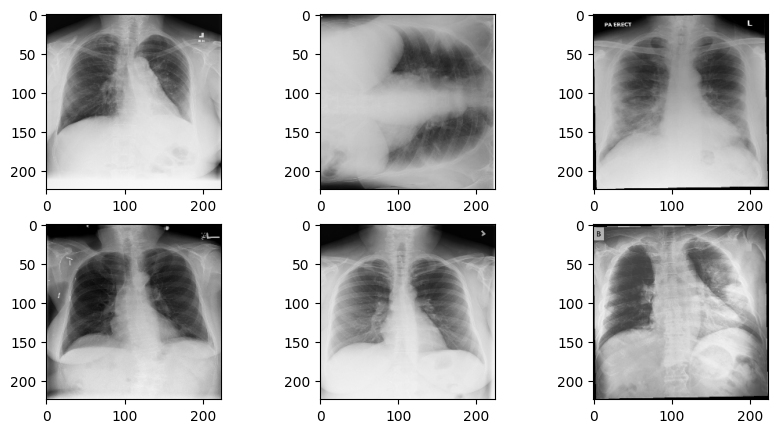

In [ ]:
images = X_train[3:9]

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')

plt.show()

In [ ]:
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')
print(f'X validation shape: {X_val.shape}, y validation shape: {y_val.shape}')
print(f'X test shape: {X_test.shape}, y test shape: {y_test.shape}')
print(np.sum(y_train.shape, y_val.shape,y_test.shape))

X train shape: (3432, 224, 224, 3), y train shape: (3432,)
X validation shape: (572, 224, 224, 3), y validation shape: (572,)
X test shape: (572, 224, 224, 3), y test shape: (572,)


# Procedure
This is a standard function i created that requires as input just a tensorflow model and provide all the information needed to compare and discuss about the models.

In [ ]:
def my_procedure(model, max_epochs, seed_value=321):
    # This function compute model performance (confusion matrix, time and memory)
    # and plot train/val acc/loss per epoch

    '''
    Input
        model: tf.keras.models.Sequential() object
        max_epochs: number of maximum epochs
    Output
        acc_test: test accuracy
        params: number of parameters in the fitted model
        time: execution time required for fitting and evaluating model
        conf_matrix: confusion matrix
    '''
    start_time = time.time()

    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    #learning_rate = 0.001
    #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

    # Training with Early Stopping (in addiction it restores best parameters wrt val loss)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Plot training vs validation accuracy and loss
   # plt.figure(figsize=(12, 4))
   # plt.subplot(1, 2, 1)
   # plt.plot(history.history['accuracy'], label='Training Accuracy')
   # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
   # plt.xlabel('Epoch')
   # plt.ylabel('Accuracy')
   # plt.legend()
   # plt.subplot(1, 2, 2)
   # plt.plot(history.history['loss'], label='Training Loss')
   # plt.plot(history.history['val_loss'], label='Validation Loss')
   # plt.xlabel('Epoch')
   # plt.ylabel('Loss')
   # plt.legend()
   # plt.show()'''

    y_pred_probabilities = model.predict(X_test) # probability X_i belongs to y_j
    y_pred = np.argmax(y_pred_probabilities, axis=1) # y_pred_i is the most probal class for X_i
    conf_matrix = confusion_matrix(y_test, y_pred)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    execution_time = (time.time() - start_time)/60

    return(test_accuracy, params/1e06, execution_time, conf_matrix)

# Models
Here we compile, train and evaluate the networks.
Each net is passed through *my_procedure()* function.

## CNN

Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


108/108 [==============================] - 20s 92ms/step - loss: 1.0684 - accuracy: 0.8141 - val_loss: 0.8115 - val_accuracy: 0.6294
Epoch 2/120
108/108 [==============================] - 7s 68ms/step - loss: 0.3926 - accuracy: 0.8963 - val_loss: 1.7496 - val_accuracy: 0.5210
Epoch 3/120
108/108 [==============================] - 7s 66ms/step - loss: 0.3504 - accuracy: 0.9001 - val_loss: 3.8648 - val_accuracy: 0.5542
Epoch 4/120
108/108 [==============================] - 7s 67ms/step - loss: 0.2336 - accuracy: 0.9251 - val_loss: 0.5242 - val_accuracy: 0.8427
Epoch 5/120
108/108 [==============================] - 7s 66ms/step - loss: 0.2481 - accuracy: 0.9190 - val_loss: 1.2576 - val_accuracy: 0.6801
Epoch 6/120
108/108 [==============================] - 7s 70ms/step - loss: 0.2476 - accuracy: 0.9257 - val_loss: 1.0195 - val_accuracy: 0.7517
Epoch 7/120
108/108 [==============================] - 7s 66ms/step - loss: 0.1907 - accuracy: 0.9368 - val_loss: 0.6136 - val_accuracy: 0.8759
Epo

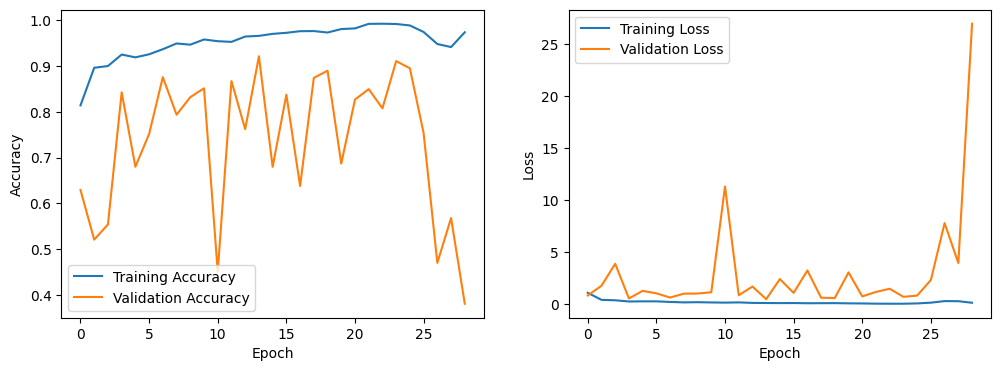

18/18 [==============================] - 0s 22ms/step - loss: 0.3618 - accuracy: 0.9231
Accuracy: 0.9230769276618958 
Number of parameters: 4.878683
Execution time: 4.567763642470042 
Confusion matrix: 
[[186   1   4]
 [ 15 173   2]
 [ 22   0 169]]


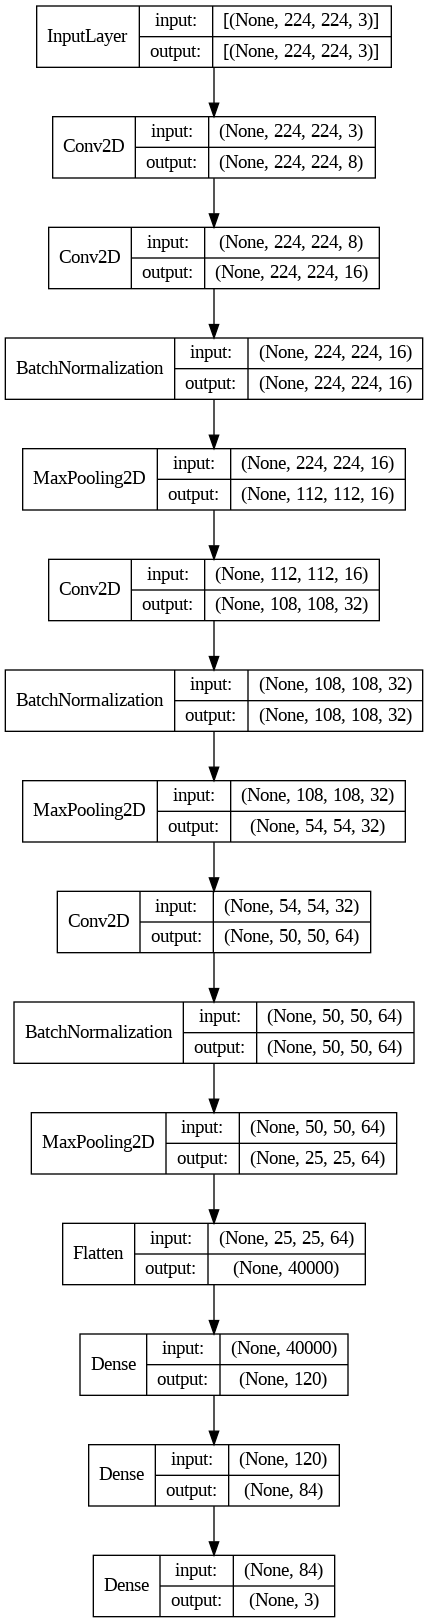

In [ ]:
CNN = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(8, 5,activation='relu', padding='same'),
            tf.keras.layers.Conv2D(16, 5,activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Conv2D(32, 5,activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Conv2D(64, 5,activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(3, activation="softmax")]) # 3=number of classes

results_CNN = my_procedure(CNN, 120)

print(f'Accuracy: {results_CNN[0]} \nNumber of parameters: {results_CNN[1]}')
print(f'Execution time: {results_CNN[2]} \nConfusion matrix: \n{results_CNN[3]}')
tf.keras.utils.plot_model(CNN, to_file='CNN.png',show_shapes=True, show_layer_names=False)
Image("CNN.png")

## Cnn_lstm

Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


108/108 [==============================] - 109s 726ms/step - loss: 0.7692 - accuracy: 0.6760 - val_loss: 2.0116 - val_accuracy: 0.2885
Epoch 2/120
108/108 [==============================] - 66s 608ms/step - loss: 0.5747 - accuracy: 0.7806 - val_loss: 2.4512 - val_accuracy: 0.3339
Epoch 3/120
108/108 [==============================] - 66s 607ms/step - loss: 0.5172 - accuracy: 0.8109 - val_loss: 1.0480 - val_accuracy: 0.4983
Epoch 4/120
108/108 [==============================] - 65s 604ms/step - loss: 0.4664 - accuracy: 0.8307 - val_loss: 1.2584 - val_accuracy: 0.5070
Epoch 5/120
108/108 [==============================] - 66s 607ms/step - loss: 0.4211 - accuracy: 0.8488 - val_loss: 1.0145 - val_accuracy: 0.5559
Epoch 6/120
108/108 [==============================] - 66s 608ms/step - loss: 0.4243 - accuracy: 0.8517 - val_loss: 1.4361 - val_accuracy: 0.4301
Epoch 7/120
108/108 [==============================] - 65s 605ms/step - loss: 0.3906 - accuracy: 0.8578 - val_loss: 1.1515 - val_accura

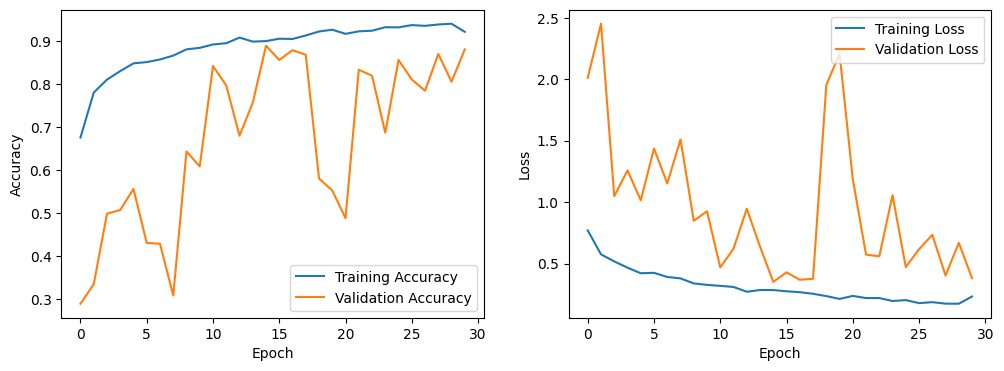

18/18 [==============================] - 2s 124ms/step - loss: 0.3227 - accuracy: 0.8951
Accuracy: 0.8951048851013184 
Number of parameters: 16.259779
Execution time: 33.645214239756264 
Confusion matrix: 
[[177  14   0]
 [ 15 174   1]
 [ 19  11 161]]


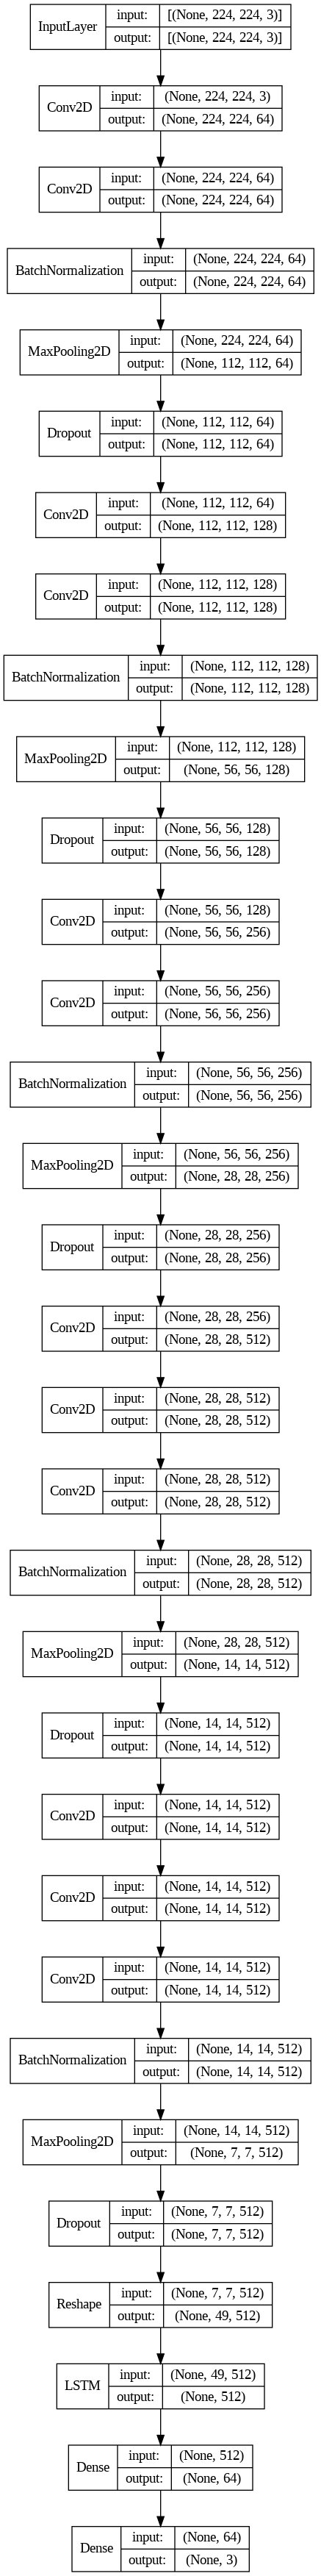

In [ ]:
def conv_block(model, output_channels, num_conv):
    for i in range(num_conv):
        model.add(tf.keras.layers.Conv2D(output_channels, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

def cnn_lstm(input_shape=(224, 224, 3)):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
    conv_block(model, output_channels = 64, num_conv = 1)

    conv_block(model, output_channels = 128, num_conv = 2)

    conv_block(model, output_channels = 256, num_conv = 2)

    conv_block(model, output_channels = 512, num_conv = 3)

    conv_block(model, output_channels = 512, num_conv = 3)

    model.add(tf.keras.layers.Reshape((49, 512)))  # Reshape per input dell'LSTM
    model.add(tf.keras.layers.LSTM(512, return_sequences=False))

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    return model

cnn_lstm_Net = cnn_lstm()

cnn_lstm_Net_Res = my_procedure(cnn_lstm_Net, 120)

print(f'Accuracy: {cnn_lstm_Net_Res[0]} \nNumber of parameters: {cnn_lstm_Net_Res[1]}')
print(f'Execution time: {cnn_lstm_Net_Res[2]} \nConfusion matrix: \n{cnn_lstm_Net_Res[3]}')
tf.keras.utils.plot_model(cnn_lstm_Net, to_file='cnn_lstm_Net.png',show_shapes=True, show_layer_names=False)
Image("cnn_lstm_Net.png")

## VGG9

Epoch 1/120
108/108 [==============================] - 22s 112ms/step - loss: 0.6721 - accuracy: 0.7104 - val_loss: 0.4727 - val_accuracy: 0.8199
Epoch 2/120
108/108 [==============================] - 9s 81ms/step - loss: 0.3682 - accuracy: 0.8770 - val_loss: 0.3617 - val_accuracy: 0.8846
Epoch 3/120
108/108 [==============================] - 8s 76ms/step - loss: 0.3058 - accuracy: 0.9001 - val_loss: 0.3424 - val_accuracy: 0.8829
Epoch 4/120
108/108 [==============================] - 9s 81ms/step - loss: 0.2690 - accuracy: 0.9091 - val_loss: 0.3083 - val_accuracy: 0.9056
Epoch 5/120
108/108 [==============================] - 8s 76ms/step - loss: 0.2240 - accuracy: 0.9269 - val_loss: 0.3145 - val_accuracy: 0.9021
Epoch 6/120
108/108 [==============================] - 9s 82ms/step - loss: 0.1988 - accuracy: 0.9356 - val_loss: 0.2994 - val_accuracy: 0.9213
Epoch 7/120
108/108 [==============================] - 8s 77ms/step - loss: 0.1871 - accuracy: 0.9353 - val_loss: 0.3406 - val_accurac

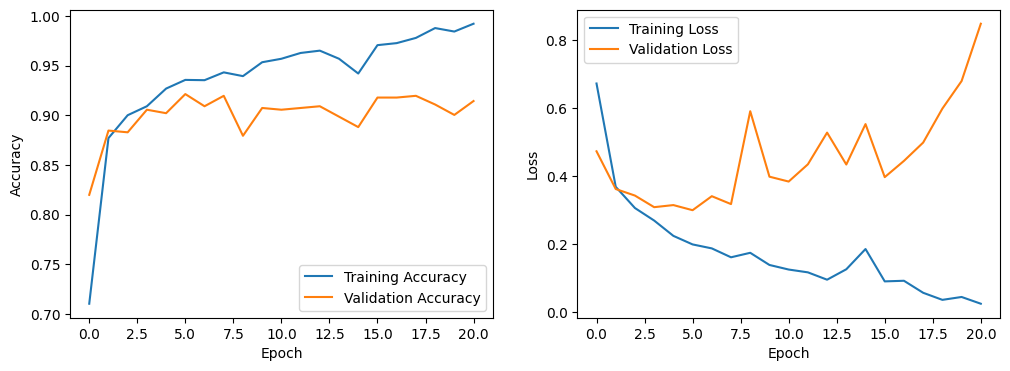

18/18 [==============================] - 0s 20ms/step - loss: 0.2931 - accuracy: 0.9108
Test Accuracy: 0.9108391404151917
Model Memory Footprint (parameters): 119840099 parameters
Minuts: 3.63
Accuracy: 0.9108391404151917 
Number of parameters: 119.8
Execution time: 3.63 
Confusion matrix: 
[[176  15   0]
 [  6 182   2]
 [ 21   7 163]]


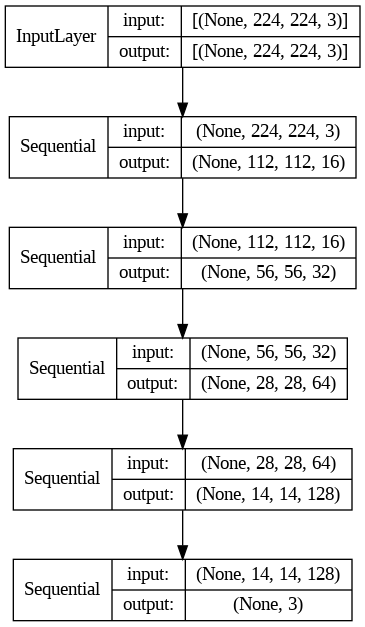

In [ ]:
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(
            tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                   padding='same', activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

def Vgg(arch):
    net = tf.keras.models.Sequential()
    for (num_convs, num_channels) in arch:
        net.add(vgg_block(num_convs, num_channels))
    net.add(
        tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3)]))
    return net
#VggNet = Vgg(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)))
VggNet = Vgg(arch=((1, 16), (1, 32), (2, 64), (2, 128)))
results_VggNet = my_procedure(VggNet, 120)

print(f'Accuracy: {results_VggNet[0]} \nNumber of parameters: {results_VggNet[1]}')
print(f'Execution time: {results_VggNet[2]} \nConfusion matrix: \n{results_VggNet[3]}')
tf.keras.utils.plot_model(VggNet, to_file='VggNet.png',show_shapes=True, show_layer_names=False)
Image("VggNet.png")

## VGG9 with Regularization

Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


108/108 [==============================] - 27s 144ms/step - loss: 2.6666 - accuracy: 0.8059 - val_loss: 1.0985 - val_accuracy: 0.3339
Epoch 2/120
108/108 [==============================] - 11s 104ms/step - loss: 0.3308 - accuracy: 0.9041 - val_loss: 1.1142 - val_accuracy: 0.3339
Epoch 3/120
108/108 [==============================] - 12s 111ms/step - loss: 0.3150 - accuracy: 0.9114 - val_loss: 0.9819 - val_accuracy: 0.6241
Epoch 4/120
108/108 [==============================] - 12s 108ms/step - loss: 0.2840 - accuracy: 0.9129 - val_loss: 0.6316 - val_accuracy: 0.7640
Epoch 5/120
108/108 [==============================] - 11s 106ms/step - loss: 0.2694 - accuracy: 0.9219 - val_loss: 0.4293 - val_accuracy: 0.8794
Epoch 6/120
108/108 [==============================] - 11s 105ms/step - loss: 0.2621 - accuracy: 0.9289 - val_loss: 0.4986 - val_accuracy: 0.8689
Epoch 7/120
108/108 [==============================] - 11s 100ms/step - loss: 0.2641 - accuracy: 0.9280 - val_loss: 1.2356 - val_accurac

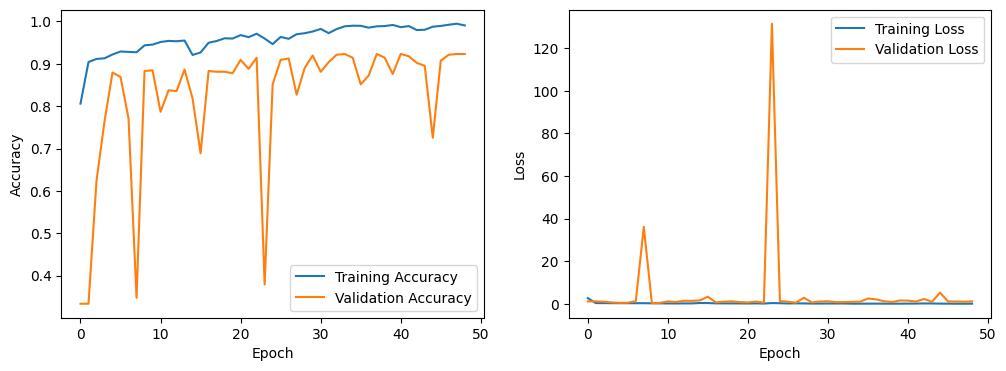

18/18 [==============================] - 0s 21ms/step - loss: 0.5769 - accuracy: 0.9301
Accuracy: 0.9300699234008789 
Number of parameters: 119.840579
Execution time: 10.625511181354522 
Confusion matrix: 
[[183   0   8]
 [ 10 179   1]
 [ 21   0 170]]


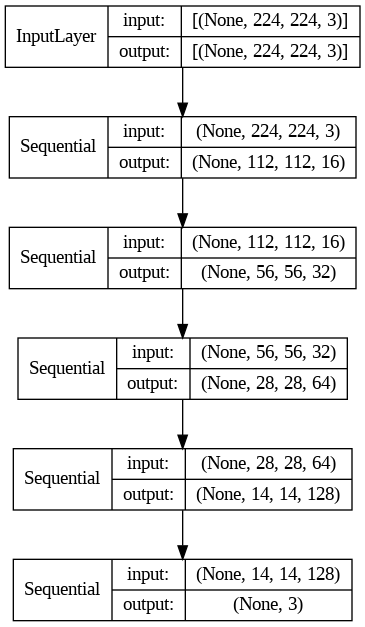

In [ ]:
def vgg_block_Reg(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(
            tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                   padding='same', activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    blk.add(tf.keras.layers.BatchNormalization())
    blk.add(tf.keras.layers.Activation('relu'))
    blk.add(tf.keras.layers.Dropout(0.10))
    return blk

def Vgg_Reg(arch):
    net = tf.keras.models.Sequential()
    for (num_convs, num_channels) in arch:
        net.add(vgg_block_Reg(num_convs, num_channels))
    net.add(
        tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation="softmax")]))
    return net
VggNet_Reg = Vgg_Reg(arch=((1, 16), (1, 32), (2, 64), (2, 128)))
results_VggNet_Reg = my_procedure(VggNet_Reg, 120)

print(f'Accuracy: {results_VggNet_Reg[0]} \nNumber of parameters: {results_VggNet_Reg[1]}')
print(f'Execution time: {results_VggNet_Reg[2]} \nConfusion matrix: \n{results_VggNet_Reg[3]}')
tf.keras.utils.plot_model(VggNet_Reg, to_file='VggNet_Reg.png',show_shapes=True, show_layer_names=False)
Image("VggNet_Reg.png")

## Covid-Net

Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


108/108 [==============================] - 91s 570ms/step - loss: 0.5294 - accuracy: 0.8179 - val_loss: 1.4658 - val_accuracy: 0.3374
Epoch 2/120
108/108 [==============================] - 53s 495ms/step - loss: 0.3749 - accuracy: 0.8738 - val_loss: 2.6807 - val_accuracy: 0.3357
Epoch 3/120
108/108 [==============================] - 53s 492ms/step - loss: 0.3446 - accuracy: 0.8869 - val_loss: 12.2421 - val_accuracy: 0.4056
Epoch 4/120
108/108 [==============================] - 53s 492ms/step - loss: 0.2953 - accuracy: 0.9047 - val_loss: 1.6687 - val_accuracy: 0.5542
Epoch 5/120
108/108 [==============================] - 53s 489ms/step - loss: 0.2870 - accuracy: 0.9009 - val_loss: 1.1802 - val_accuracy: 0.6031
Epoch 6/120
108/108 [==============================] - 53s 488ms/step - loss: 0.2613 - accuracy: 0.9161 - val_loss: 18.8798 - val_accuracy: 0.3339
Epoch 7/120
108/108 [==============================] - 53s 492ms/step - loss: 0.2627 - accuracy: 0.9175 - val_loss: 28.4910 - val_accu

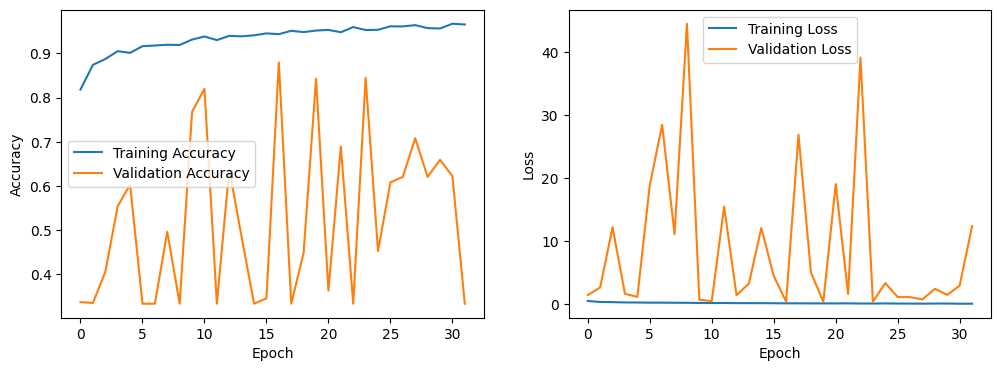

18/18 [==============================] - 2s 133ms/step - loss: 0.3893 - accuracy: 0.8811
Accuracy: 0.881118893623352 
Number of parameters: 0.7
Execution time: 29.1 
Confusion matrix: 
[[188   2   1]
 [ 35 149   6]
 [ 24   0 167]]


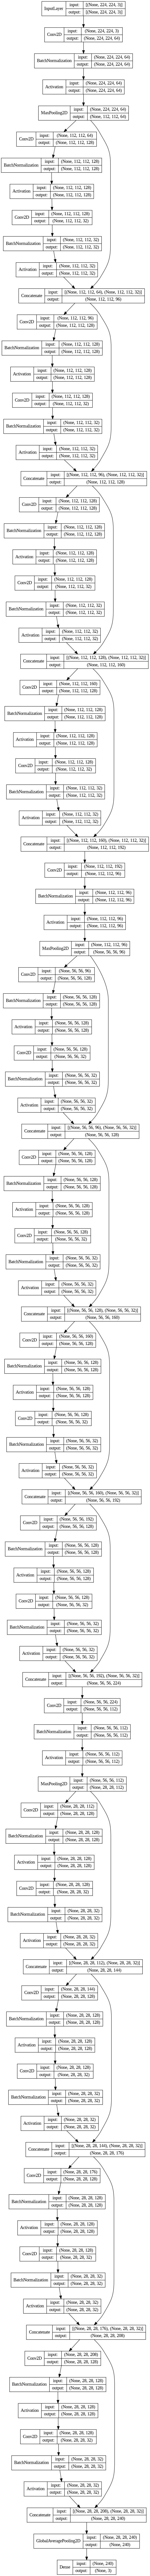

In [ ]:
def conv_block(x, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        conv = conv_block(x, growth_rate * 4, 1)
        conv = conv_block(conv, growth_rate, 3)
        x = concatenate([x, conv], axis=-1)
    return x

def transition_block(x, compression_factor):
    num_filters = int(tf.keras.backend.int_shape(x)[-1] * compression_factor)
    x = Conv2D(num_filters, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    return x

def COVIDNet(input_shape, num_classes, num_dense_blocks=3, num_layers_per_block=4, growth_rate=32, compression_factor=0.5):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = conv_block(inputs, 64, 7)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Dense Blocks and Transition Blocks
    for i in range(num_dense_blocks):
        x = dense_block(x, num_layers_per_block, growth_rate)
        if i < num_dense_blocks - 1:
            x = transition_block(x, compression_factor)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (224, 224, 3)
COVID_Net = COVIDNet(input_shape, num_classes=3)
COVID_Net_Res = my_procedure(COVID_Net, 120)

print(f'Accuracy: {COVID_Net_Res[0]} \nNumber of parameters: {COVID_Net_Res[1]}')
print(f'Execution time: {COVID_Net_Res[2]} \nConfusion matrix: \n{COVID_Net_Res[3]}')
tf.keras.utils.plot_model(COVID_Net, to_file='COVID_Net.png',show_shapes=True, show_layer_names=False)
Image("COVID_Net.png")

## CVID-Net + Regolarization

Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


108/108 [==============================] - 103s 724ms/step - loss: 0.5795 - accuracy: 0.7853 - val_loss: 2.6562 - val_accuracy: 0.3269
Epoch 2/120
108/108 [==============================] - 72s 667ms/step - loss: 0.3999 - accuracy: 0.8695 - val_loss: 3.4016 - val_accuracy: 0.4021
Epoch 3/120
108/108 [==============================] - 72s 669ms/step - loss: 0.3713 - accuracy: 0.8753 - val_loss: 3.3352 - val_accuracy: 0.4878
Epoch 4/120
108/108 [==============================] - 72s 669ms/step - loss: 0.3267 - accuracy: 0.8916 - val_loss: 2.9551 - val_accuracy: 0.4388
Epoch 5/120
108/108 [==============================] - 73s 672ms/step - loss: 0.3037 - accuracy: 0.9036 - val_loss: 12.3901 - val_accuracy: 0.3357
Epoch 6/120
108/108 [==============================] - 72s 671ms/step - loss: 0.2872 - accuracy: 0.9056 - val_loss: 166.6320 - val_accuracy: 0.3339
Epoch 7/120
108/108 [==============================] - 72s 669ms/step - loss: 0.2870 - accuracy: 0.9041 - val_loss: 19.2520 - val_ac

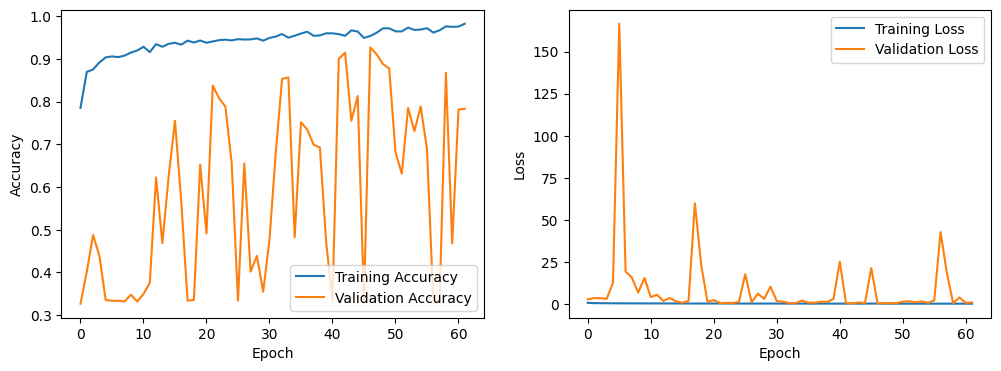

18/18 [==============================] - 2s 131ms/step - loss: 0.2370 - accuracy: 0.9178
Accuracy: 0.9178321957588196 
Number of parameters: 0.715587
Execution time: 75.34298861821493 
Confusion matrix: 
[[188   1   2]
 [ 12 168  10]
 [ 22   0 169]]


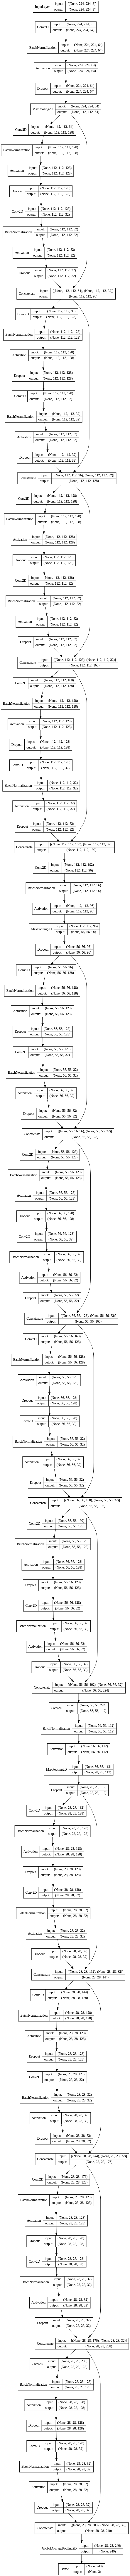

In [ ]:
def conv_block(x, filters, kernel_size, dropout_rate=None, l2_reg=None):
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

def dense_block(x, num_layers, growth_rate, dropout_rate=None, l2_reg=None):
    for _ in range(num_layers):
        conv = conv_block(x, growth_rate * 4, 1, dropout_rate, l2_reg)
        conv = conv_block(conv, growth_rate, 3, dropout_rate, l2_reg)
        x = concatenate([x, conv], axis=-1)
    return x

def transition_block(x, compression_factor, dropout_rate=None, l2_reg=None):
    num_filters = int(tf.keras.backend.int_shape(x)[-1] * compression_factor)
    x = Conv2D(num_filters, 1, padding='same', kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

def COVIDNetReg(input_shape, num_classes, num_dense_blocks=3, num_layers_per_block=4, growth_rate=32, compression_factor=0.5, dropout_rate=0.2, l2_reg=None):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = conv_block(inputs, 64, 7, dropout_rate, l2_reg)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Dense Blocks and Transition Blocks
    for i in range(num_dense_blocks):
        x = dense_block(x, num_layers_per_block, growth_rate, dropout_rate, l2_reg)
        if i < num_dense_blocks - 1:
            x = transition_block(x, compression_factor, dropout_rate, l2_reg)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2_reg)(x)

    model = Model(inputs, outputs)
    return model


input_shape = (224, 224, 3)
l2_reg = regularizers.l2(0)  # Aggiunta regolarizzazione L2
COVID_Net_Reg = COVIDNetReg(input_shape, num_classes=3, dropout_rate=0.10, l2_reg=l2_reg)

COVID_Net_Reg_Res = my_procedure(COVID_Net_Reg, 120)

print(f'Accuracy: {COVID_Net_Reg_Res[0]} \nNumber of parameters: {COVID_Net_Reg_Res[1]}')
print(f'Execution time: {COVID_Net_Reg_Res[2]} \nConfusion matrix: \n{COVID_Net_Reg_Res[3]}')
tf.keras.utils.plot_model(COVID_Net_Reg, to_file='COVID_Net_Reg.png',show_shapes=True, show_layer_names=False)
Image("COVID_Net_Reg.png")

## Logistic Lasso (OVR)

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_train_flat = np.concatenate((X_train_flat,X_val_flat))
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_train_flat = np.concatenate((y_train, y_val))
model = LogisticRegression(penalty='l1', solver='saga',
                           multi_class='ovr', max_iter=100)

start_time = time.time()
model.fit(X_train_flat, y_train_flat)
training_time = time.time() - start_time

print(f"Tempo di addestramento: {training_time} secondi")


y_test_pred = model.predict(X_test_flat)


test_conf = confusion_matrix(y_test, y_test_pred)


print(f"Accuratezza su test set: {test_conf}")


num_non_zero_params = np.sum(model.coef_ != 0)
print(f"Number of non-zero parameters: {num_non_zero_params}")

Tempo di addestramento: 2964.8893191814423 secondi
Accuratezza su test set: [[168  16   7]
 [ 12 169   9]
 [ 19   3 169]]
Number of non-zero parameters: 252959


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
print(training_time/60)
print(num_non_zero_params/1e06)
np.sum(model.coef_ != 0)/(np.sum(model.coef_ == 0)+np.sum(model.coef_ != 0))

49.414821986357374
0.252959


0.5601593501984127

# Results
## CNN

1.   Accuracy: 92.31%
2.   Memory occupation: 4.87 (millions trainable parameters)
3.   Time required: 4.57 minuts


## CNN-LSTM

1.   Accuracy: 89.51%
2.   Memory occupation: 16.26 (millions trainable parameters)
3.   Time required: 33.64 minuts


## VGG6

1.   Accuracy: 91.08%
2.   Memory occupation: 119.8 (millions trainable parameters)
3.   Time required: 3.63 minuts


## COVID-Net

1.   Accuracy: 88.11%
2.   Memory occupation: 0.711 (millions trainable parameters)
3.   Time required: 29.01 minuts


## COVID-Net with Regularization

1.   Accuracy: 91.78%
2.   Memory occupation: 0.711 (millions trainable parameters)
3.   Time required: 75.34 minuts


## Logistic Lasso

1.   Accuracy: 88.48%
2.   Memory occupation: 0.253 (millions trainable parameters)
3.   Time required: 49.41 minuts

# Metrics calculation

In [ ]:
def calculate_metrics(confusion_matrix):
    # Verifica che la matrice di confusione sia 3x3
    if confusion_matrix.shape != (3, 3):
        raise ValueError("La matrice di confusione deve essere 3x3")

    # Inizializzazione delle variabili per le somme delle metriche
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    num_classes = confusion_matrix.shape[0]

    # Calcolo delle metriche per ciascuna classe
    metrics = {}
    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_positives = sum(confusion_matrix[:, i]) - true_positives
        false_negatives = sum(confusion_matrix[i, :]) - true_positives
        true_negatives = sum(confusion_matrix) - (true_positives + false_positives + false_negatives)

        # Precision
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0

        # Recall
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0

        # F1-Score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        metrics[f'Class {i}'] = {
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1_score
        }

        # Aggiornamento delle somme
        total_precision += precision
        total_recall += recall
        total_f1_score += f1_score

    # Calcolo delle medie
    average_precision = total_precision / num_classes
    average_recall = total_recall / num_classes
    average_f1_score = total_f1_score / num_classes

    # Aggiunta delle medie al dizionario delle metriche
    metrics['Average'] = {
        'Precision': average_precision,
        'Recall': average_recall,
        'F1-Score': average_f1_score
    }

    return metrics

## CNN

In [ ]:
# Esempio di utilizzo
confusion_matrix = np.array([
 [186,   1,   4],
 [ 15, 173,   2],
 [ 22,   0, 169]])

metrics = calculate_metrics(confusion_matrix)
for class_label, class_metrics in metrics.items():
    print(f"{class_label}:")
    for metric_name, metric_value in class_metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")

Class 0:
  Precision: 0.83
  Recall: 0.97
  F1-Score: 0.90
Class 1:
  Precision: 0.99
  Recall: 0.91
  F1-Score: 0.95
Class 2:
  Precision: 0.97
  Recall: 0.88
  F1-Score: 0.92
Average:
  Precision: 0.93
  Recall: 0.92
  F1-Score: 0.92


## CCN-LSTM

In [ ]:
confusion_matrix = np.array([
 [177,  14,   0],
 [ 15, 174,   1],
 [ 19,  11, 161]
    ])

metrics = calculate_metrics(confusion_matrix)
for class_label, class_metrics in metrics.items():
    print(f"{class_label}:")
    for metric_name, metric_value in class_metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")

Class 0:
  Precision: 0.84
  Recall: 0.93
  F1-Score: 0.88
Class 1:
  Precision: 0.87
  Recall: 0.92
  F1-Score: 0.89
Class 2:
  Precision: 0.99
  Recall: 0.84
  F1-Score: 0.91
Average:
  Precision: 0.90
  Recall: 0.90
  F1-Score: 0.90


## VGG6

In [ ]:
confusion_matrix = np.array(
 [[176,  15,   0],
 [  6, 182,   2],
 [ 21,   7, 163]]
)

metrics = calculate_metrics(confusion_matrix)
for class_label, class_metrics in metrics.items():
    print(f"{class_label}:")
    for metric_name, metric_value in class_metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")

Class 0:
  Precision: 0.87
  Recall: 0.92
  F1-Score: 0.89
Class 1:
  Precision: 0.89
  Recall: 0.96
  F1-Score: 0.92
Class 2:
  Precision: 0.99
  Recall: 0.85
  F1-Score: 0.92
Average:
  Precision: 0.92
  Recall: 0.91
  F1-Score: 0.91


## VGG6 with Regularization

In [ ]:
confusion_matrix = np.array(
 [[183,   0,   8],
 [ 10, 179,   1],
 [ 21,   0, 170]]
)

metrics = calculate_metrics(confusion_matrix)
for class_label, class_metrics in metrics.items():
    print(f"{class_label}:")
    for metric_name, metric_value in class_metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")

Class 0:
  Precision: 0.86
  Recall: 0.96
  F1-Score: 0.90
Class 1:
  Precision: 1.00
  Recall: 0.94
  F1-Score: 0.97
Class 2:
  Precision: 0.95
  Recall: 0.89
  F1-Score: 0.92
Average:
  Precision: 0.93
  Recall: 0.93
  F1-Score: 0.93


## COVID-Net

In [ ]:
confusion_matrix = np.array(
 [[188,   2,   1],
 [ 35, 149,   6],
 [ 24,   0, 167]]
)

metrics = calculate_metrics(confusion_matrix)
for class_label, class_metrics in metrics.items():
    print(f"{class_label}:")
    for metric_name, metric_value in class_metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")

Class 0:
  Precision: 0.76
  Recall: 0.98
  F1-Score: 0.86
Class 1:
  Precision: 0.99
  Recall: 0.78
  F1-Score: 0.87
Class 2:
  Precision: 0.96
  Recall: 0.87
  F1-Score: 0.92
Average:
  Precision: 0.90
  Recall: 0.88
  F1-Score: 0.88


## COVID-Net with Regularization

In [ ]:
confusion_matrix = np.array(
 [[188,   1,   2],
 [ 12, 168, 10],
 [ 22,   0, 169]]
)

metrics = calculate_metrics(confusion_matrix)
for class_label, class_metrics in metrics.items():
    print(f"{class_label}:")
    for metric_name, metric_value in class_metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")

Class 0:
  Precision: 0.85
  Recall: 0.98
  F1-Score: 0.91
Class 1:
  Precision: 0.99
  Recall: 0.88
  F1-Score: 0.94
Class 2:
  Precision: 0.93
  Recall: 0.88
  F1-Score: 0.91
Average:
  Precision: 0.92
  Recall: 0.92
  F1-Score: 0.92


## Logistic Lasso

In [ ]:
confusion_matrix = np.array(
 [[168,  16,   7],
 [ 12, 169,   9],
 [ 19,   3, 169]]
)
metrics = calculate_metrics(confusion_matrix)
for class_label, class_metrics in metrics.items():
    print(f"{class_label}:")
    for metric_name, metric_value in class_metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")

Class 0:
  Precision: 0.84
  Recall: 0.88
  F1-Score: 0.86
Class 1:
  Precision: 0.90
  Recall: 0.89
  F1-Score: 0.89
Class 2:
  Precision: 0.91
  Recall: 0.88
  F1-Score: 0.90
Average:
  Precision: 0.89
  Recall: 0.88
  F1-Score: 0.88
